In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import FeaturePyramidNetwork

import torch
import torch.nn as nn

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from utils.dataset import Dataset

from scipy.stats import pearsonr as corr


In [2]:
batch_size = 32

In [3]:
data = Dataset('../../data/subj08')
#test_data = Dataset('../../data/subj08', test=True)

train_set, val_set = torch.utils.data.random_split(data, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)


In [5]:
# loading pretrained model
device = torch.device("cuda")

model = resnet50(weights=ResNet50_Weights.DEFAULT)

layer_names = []

for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer_names += [name]

print(layer_names)

feature_extractor = create_feature_extractor(model, 
        return_nodes=["layer1.0.conv3", "layer2.0.conv3", "layer3.0.conv3", "layer4.0.conv3"]).to(device)

fpn = FeaturePyramidNetwork([64, 128, 256, 512], 256).to(device)

feature_extractor.eval()

['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Module(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [6]:
class RegressionHead(torch.nn.Module):
    def __init__(self, outputSize):
        super(RegressionHead, self).__init__()

        self.flatten = nn.Flatten()

        self.conv1 = nn.Conv2d(1024, 512, 3)
        self.pool = nn.MaxPool2d(2)

        self.linear1 = nn.Linear(18432, 6000)
        self.linear2 = nn.Linear(6000, outputSize)

    def forward(self, x):
        output = self.conv1(x)
        output = self.pool(output)

        output = self.flatten(output)

        output = self.linear1(output)

        return self.linear2(output)

In [7]:
regression_head = RegressionHead(18981).to(device)
regression_head.to(device)

RegressionHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=18432, out_features=6000, bias=True)
  (linear2): Linear(in_features=6000, out_features=18981, bias=True)
)

In [8]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)

In [9]:
losses = []
val_losses = []

for epoch in range(10):
    print(f"Epoch {epoch}")
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)-1):
        optimizer.zero_grad()

        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
        
        output = regression_head(output["layer3.0.conv3"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
        
        if i == len(train_loader)-1:
            losses.append(loss.item())
            print("Train loss: " + str(loss.item()))

        loss.backward()

        del input_data
        del left_label
        
        optimizer.step()
    
    for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
            output = regression_head(output["layer3.0.conv3"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))

        del input_data
        del left_label
        
        if i == len(val_loader)-1:
            val_losses.append(loss.item())
            print("Val loss: " + str(loss.item()))

Epoch 0


  0%|          | 0/274 [00:00<?, ?it/s]/tmp/ipykernel_34742/3388305325.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
 37%|███▋      | 101/274 [00:43<01:04,  2.68it/s]

Text(0.5, 1.0, 'Loss over time, lr=0.0001, epochs=50, batch_size=64')

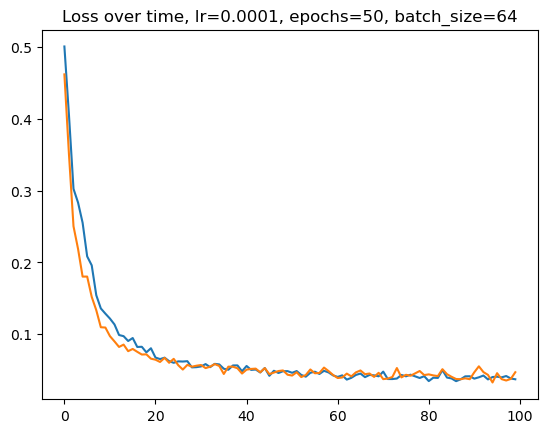

In [10]:
plt.plot(losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.title("Loss over time, lr=0.0001, epochs=50, batch_size=64")

In [7]:
labels_val = np.array([])
predicted_val = np.array([])

for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
    input_data = data[0]
    left_label = data[1]

    output = feature_extractor(input_data.to(device))
    output = regression_head(output["layer3.0.conv3"])

    if labels_val.shape[0] == 0:
        labels_val = left_label.detach().cpu().numpy()
        predicted_val = output.detach().cpu().numpy()
    else:
        labels_val = np.vstack((labels_val, left_label.detach().cpu().numpy()))
        predicted_val = np.vstack((predicted_val, output.detach().cpu().numpy()))

55it [00:30,  1.78it/s]                        


In [8]:
from scipy.stats import pearsonr as corr

# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(predicted_val.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(predicted_val.shape[1])):
    lh_correlation[v] = corr(predicted_val[:,v], labels_val[:,v])[0]

score = (np.median(lh_correlation**2)) * 100
print(score)

100%|██████████| 18981/18981 [00:01<00:00, 10440.85it/s]

1.6658856191187625e-05
